In [1]:
import os
import glob
import io
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

import cv2
from PIL import Image

# Tensorflow
import tensorflow as tf
import keras
from keras import layers

# Imaging
import xarray as xr
import imageio.v2 as imageio
from ipywidgets import widgets, Layout, HBox

# Default year range
year_range = range(2015, 2024)

use_existing_npy = False

# Set seed fpr reproducible results in model fitting
tf.random.set_seed(31415)
np.random.seed(31415)

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(gpus))
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


## Notebook functions

In [3]:
def get_path(parts):
    out_path = ""
    for part in parts:
        out_path = out_path + f"{part}{os.path.sep}"

    out_path = out_path.rstrip(os.path.sep)
    return out_path

## Image reading functions

In [4]:
# Define a function to load a single .nc file for a given year and day
def load_nc_file(year, day, file_path=None) -> xr.Dataset:
    """Loads the cropped, grid-corrected netcdf files on the Beaufort Sea with 74,0lat_-170,0lon"""
    # Generate the file path based on the year and day
    if file_path == None:
        file_path = os.path.join(
            data_root,
            str(year),
            f"ims{year}{day:03d}_1km_v1.3_grid{WINDOW_SIZE}_74,0lat_-170,0lon.nc",
        )

        if not os.path.exists(file_path):
            # Use imputed data file
            file_path = os.path.join(
                data_root,
                str(year),
                f"ims{year}{day:03d}_1km_v1.3#_grid{WINDOW_SIZE}_74,0lat_-170,0lon.nc",
            )

    # Load the .nc file using xarray
    with xr.open_dataset(file_path) as dataset:
        return dataset

In [5]:
def crop_to_beaufort_sea(ds: xr.Dataset, window_size: int) -> xr.Dataset:
    """
    Center window on beaufort sea coordinates in **current** netcdf coordinate system (not quite polar stereographic) and
    crop to WINDOW_SIZE x WINDOW_SIZE (not 2*window size x 2*window size as was previously)
    """
    # Beaufort Sea x, y in **current** IMS netcdf coordinate system
    #     x = -1652603.364653003  # meters
    x = -2052603.364653003  # meters
    #     y = -291398.56159791426  # meters
    y = -221398.56159791426  # meters

    # These x, y in convert back to the below with current geolocation.py functions.
    ## longitude: -80.0, latitude: 74.0
    # Actual Beaufort Sea coordinates are closer to longitude: -140, latitude: 74.

    beaufort_ds = ds.sel(
        x=slice(x - 1000 * window_size // 2, x + 1000 * window_size // 2),
        y=slice(y - 1000 * window_size // 2, y + 1000 * window_size // 2),
    )
    return beaufort_ds

In [6]:
def load_sie_data(year, day, file_path=None) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    return load_nc_file(year, day, file_path).IMS_Surface_Values[0].values.copy()

In [7]:
def load_target_sie_data(year, day) -> np.array:
    """Returns a 2D numpy array copy of the IMS surface values"""
    ds = load_nc_file(year, day)
    sie = ds.IMS_Surface_Values[0].values.copy()
    binary_sie = sie.copy()
    binary_sie[sie != 3] = 0

    # Sea and Lake Ice is treated as 1
    binary_sie[sie == 3] = 1
    return binary_sie

In [8]:
def binarize_data(sie: np.array) -> np.array:
    """
    New SIE:
    0: Open water/out of bounds
    1: Sea ice or lake ice (lake mask not applied)
    2: Land
    """
    binary_sie = sie.copy()
    binary_sie[sie != 3] = 0

    # Sea and Lake Ice is treated as 1
    binary_sie[sie == 3] = 1

    # Land and Snow-Covered Land is sent to 2.
    #     binary_sie[sie == 2] = 2
    #     binary_sie[sie == 4] = 2
    return binary_sie

In [9]:
def load_n_day_chunk(year: int, day: int, n=4) -> np.array:
    """
    Return np.array with shape (height, width, channels).

    Does NOT wrap years or account for missing days.
    Starts n_day chunk at specified day, year.

    Returns:
        np.array: shape (sie_y_shape, sie_x_shape, n_day)
    """
    sie_chunk = []
    for day in range(day, day + n):
        sie = binarize_data(load_sie_data(year, day))
        sie_chunk.append(sie)

    assert len(sie_chunk) == n
    # Use np.stack to stack the individual 2D arrays along a new third axis, resulting in (height, width, channels)
    return np.stack(sie_chunk, axis=-1)

## Create cropped netcdf files to Beaufort Sea

In [10]:
WINDOW_SIZE = 1000
overwrite = False
for year in range(2015, 2024):
    print(f"Converting all netcdf files for {year}")
    data_root = get_path(["D:", "IceDyno", "IMS_images"])
    save_dir = get_path(["D:", "IceDyno", "IMS_images_beaufort", year])
    os.makedirs(save_dir, exist_ok=True)
    day = 1
    for hdf5_file in glob.glob(get_path([data_root, year, "*.nc"])):
        resized_file = get_path(
            [
                save_dir,
                f"ims{year}{day:03d}_1km_v1.3_grid{WINDOW_SIZE}_74,0lat_-170,0lon.nc",
            ]
        )
        if not os.path.exists(resized_file) or overwrite == True:
            data = load_nc_file(year, day, hdf5_file)
            beaufort_data = crop_to_beaufort_sea(data, WINDOW_SIZE)
            beaufort_data.to_netcdf(resized_file)
        day += 1

Converting all netcdf files for 2015
Converting all netcdf files for 2016
Converting all netcdf files for 2017
Converting all netcdf files for 2018
Converting all netcdf files for 2019
Converting all netcdf files for 2020
Converting all netcdf files for 2021
Converting all netcdf files for 2022
Converting all netcdf files for 2023


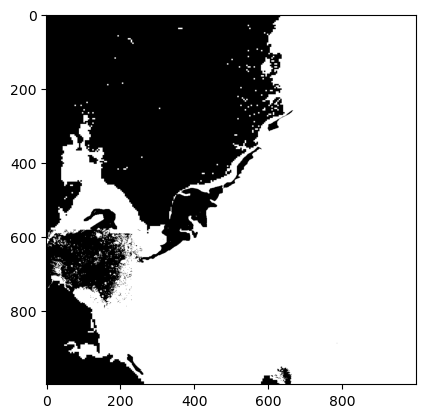

In [11]:
# Example usage:
example = True
if example:
    year = 2023
    day = 150
    #     data_root = get_path(["D:", "IceDyno", "IMS_images"])
    #     multiclass_sie = load_sie_data(year, day, get_path([data_root, 2015, "ims2015210_1km_v1.3.nc"]))
    #     sie = binarize_data(multiclass_sie)
    #     plt.imshow(multiclass_sie)
    #     plt.show()

    data_root = get_path(["D:", "IceDyno", "IMS_images_beaufort"])
    multiclass_sie = load_sie_data(
        year, day
    )  # , get_path([data_root, 2015, "ims2015001_1km_v1.3_grid1000_74,0lat_-170,0lon.nc"]))
    sie = binarize_data(multiclass_sie)
    plt.imshow(sie, cmap="gray")
    plt.show()

## Load CSV files that lists dates and file names

In [12]:
root_dir = get_path(["D:", "IceDyno", "IMS_images_converted"])
dfs = []
for yr in year_range:
    csv_filename = get_path([root_dir, yr, "image_dates.csv"])
    if os.path.exists(csv_filename):
        df = pd.read_csv(csv_filename, index_col=False)
        dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df["Date"] = pd.to_datetime(df["Date"])

display(df)

,File Name,Date,Impute
0,ims2015001_1km_v1.3.nc,2015-01-01,N
1,ims2015002_1km_v1.3.nc,2015-01-02,N
2,ims2015003_1km_v1.3.nc,2015-01-03,N
3,ims2015004_1km_v1.3.nc,2015-01-04,N
4,ims2015005_1km_v1.3.nc,2015-01-05,N
...,...,...,...
3282,ims2023361_1km_v1.3.nc,2023-12-27,N
3283,ims2023362_1km_v1.3.nc,2023-12-28,N
3284,ims2023363_1km_v1.3.nc,2023-12-29,N
3285,ims2023364_1km_v1.3.nc,2023-12-30,N


## Load ranges of dates

In [13]:
def build_sequences(curr_month):
    file_names = {}
    for yr in year_range:
        if curr_month == 2:
            # Ignore extra day for leap year
            df_filtered = df[
                (df["Date"] >= f"{yr}-02-01") & (df["Date"] <= f"{yr}-02-28")
            ]
        else:
            df_filtered = df[
                (df["Date"].dt.month == curr_month) & (df["Date"].dt.year == yr)
            ]

        file_names[yr] = df_filtered["File Name"].tolist()

    return file_names

## Shape arrays [sequences, samples, height, width]

In [14]:
def build_array(years, days):
    img_width = WINDOW_SIZE
    img_height = WINDOW_SIZE
    img_array = np.zeros((len(days), len(years), img_width, img_height))

    # Load png files
    for year_idx, year in enumerate(years):
        for day_idx, day in enumerate(days):
            multiclass_sie = load_sie_data(year, day)
            sie = binarize_data(multiclass_sie)
            img_array[day_idx, year_idx] = sie

    print(f"\tInput data of image files: {img_array.shape}")

    # Swap the axes representing the number of frames and number of data samples.
    img_array = np.swapaxes(img_array, 0, 1)
    print(f"\tSwap axes: {img_array.shape}")

    # Add a channel dimension since the images are grayscale.
    img_array = np.expand_dims(img_array, axis=-1)
    print(f"\tReshaped array for model: {img_array.shape}")

    return img_array

In [15]:
def build_array_weeks(year, start_day, sets=8, days_per_set=5):
    img_width = WINDOW_SIZE
    img_height = WINDOW_SIZE
    img_array = np.zeros((days_per_set, sets, img_width, img_height))

    # Load png files
    for set_idx in range(sets):
        for day_idx, day in enumerate(range(start_day, start_day + days_per_set)):
            multiclass_sie = load_sie_data(year, day)
            sie = binarize_data(multiclass_sie)
            img_array[day_idx, set_idx] = sie
        start_day += days_per_set

    print(f"\tInput data of image files: {img_array.shape}")

    # Swap the axes representing the number of frames and number of data samples.
    img_array = np.swapaxes(img_array, 0, 1)
    print(f"\tSwap axes: {img_array.shape}")

    # Add a channel dimension since the images are grayscale.
    img_array = np.expand_dims(img_array, axis=-1)
    print(f"\tReshaped array for model: {img_array.shape}")

    return img_array

## Create train/val/test

In [16]:
def create_datasets(png_array):
    # Split into train and validation sets using indexing to optimize memory.
    indexes = np.arange(png_array.shape[0])
    np.random.shuffle(indexes)
    train_index = indexes[: int(0.9 * png_array.shape[0])]
    val_index = indexes[int(0.9 * png_array.shape[0]) :]
    train_dataset = png_array[train_index]
    val_dataset = png_array[val_index]

    #     # Normalize the data to the 0-1 range.
    #     train_dataset = train_dataset / 255
    #     val_dataset = val_dataset / 255

    # We'll define a helper function to shift the frames, where
    # `x` is frames 0 to n - 1, and `y` is frames 1 to n.
    def create_shifted_frames(data):
        x = data[:, 0 : data.shape[1] - 1, :, :]
        y = data[:, 1 : data.shape[1], :, :]
        return x, y

    # Apply the processing function to the datasets.
    x_train, y_train = create_shifted_frames(train_dataset)
    x_val, y_val = create_shifted_frames(val_dataset)

    # Inspect the dataset.
    print(
        "\tTraining Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape)
    )
    print("\tValidation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

    return train_dataset, val_dataset, x_train, y_train, x_val, y_val

## Data Visualization

In [17]:
def plot_orig_imgs(train_dataset):
    # Construct a figure on which we will visualize the images.
    fig, axes = plt.subplots(1, train_dataset.shape[1], figsize=(16, 6))

    # Plot each of the sequential images for one random data example.
    data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
    for idx, ax in enumerate(axes.flat):
        ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.axis("off")

    # Print information and display the figure.
    print(f"\tDisplaying frames for example {data_choice}.")
    plt.tight_layout()
    plt.suptitle(f"Sample Training Images", y=1.025, fontsize=16)
    plt.show()

## Model Construction

In [18]:
def build_model():
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        # Construct the input layer with no definite frame size.
        inp = layers.Input(shape=(None, *x_train.shape[2:]))

        # We will construct 3 `ConvLSTM2D` layers with batch normalization,
        # followed by a `Conv3D` layer for the spatiotemporal outputs.
        x = layers.ConvLSTM2D(
            filters=16,
            kernel_size=(5, 5),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(inp)
        x = layers.BatchNormalization()(x)
        x = layers.ConvLSTM2D(
            filters=16,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.ConvLSTM2D(
            filters=16,
            kernel_size=(1, 1),
            padding="same",
            return_sequences=True,
            activation="relu",
        )(x)
        x = layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        )(x)

        # Next, we will build the complete model and compile it.
        model = keras.models.Model(inp, x)
        model.compile(
            loss=keras.losses.binary_crossentropy,
            optimizer=keras.optimizers.Adam(),
        )

    #         model.summary()

    # Free up GPU resources
    tf.keras.backend.clear_session()

    return model

## Fit Model

In [19]:
def fit_model(model, month):
    print(f"\tTraining model for {month}")
    # Define some callbacks to improve training.
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

    # Define modifiable training hyperparameters.
    epochs = 100
    batch_size = 1

    # Fit the model to the training data.
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=0,
    )

    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    # plt.ylim(0.035, 0.11)
    plt.show()

    print(
        f"\tMin loss: {(history.history['loss'][np.argmin(history.history['loss'])]):.4f}"
    )
    print(
        f"\tMin val_loss: {(history.history['val_loss'][np.argmin(history.history['val_loss'])]):.4f}"
    )

    today = datetime.today()
    formatted_date = today.strftime("%m%d%y")
    model.save(f"{formatted_date}_{month}.h5py")

    # Free up GPU resources
    tf.keras.backend.clear_session()

    return model

## Frame Prediction Visualizations

In [20]:
def predict(model, val_dataset, month):
    # Select a random example from the validation dataset.
    example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

    offset = len(val_dataset) // 2
    # Pick the first/last ten frames from the example.
    frames = example[:offset, ...]
    original_frames = example[offset:, ...]

    # Predict a new set of 10 frames.
    for _ in range(len(val_dataset)):
        # Extract the model's prediction and post-process it.
        new_prediction = model.predict(np.expand_dims(frames, axis=0), verbose=0)
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 2, figsize=(16, 6))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
        ax.set_title(f"Actual Frame {idx}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[:offset, ...]
    for idx, ax in enumerate(axes[1]):
        test_frames = (new_frames[0] * 255).astype(int)
        threshold = int(np.mean(np.unique(new_frames[0] * 255)))
        test_frames[test_frames < threshold] = 0
        test_frames[test_frames >= threshold] = 255
        ax.imshow(np.squeeze(test_frames), cmap="gray")
        ax.set_title(f"Predicted Frame {idx}")
        ax.axis("off")

    # Display the figure.
    plt.suptitle(f"Predicted and Actual Images for {month}", y=1.025, fontsize=16)
    plt.show()

In [21]:
def predict_test(model, test_dataset):
    pred = model.predict(test_dataset)

    fig, axs = plt.subplots(2, 4, figsize=(10, 6))
    axs = axs.flatten()
    offset = 0

    for idx, ax in enumerate(axs):
        if idx < 4:
            ax.imshow(pred[0][idx], cmap="gray")
            ax.set_title(f"{idx + 1} days out")
        else:
            ax.imshow(test_dataset[0][idx - 4], cmap="gray")
            ax.set_title(f"Actual image {offset + 1} days out")
            offset += 1

    plt.tight_layout()
    plt.suptitle("Prediction and Actual images for 2023 Starting at Day 210")
    plt.show()

## Predicted Videos

Running model for 120 Days in 2023 starting at day 90
	Input data of image files: (4, 30, 1000, 1000)
	Swap axes: (30, 4, 1000, 1000)
	Reshaped array for model: (30, 4, 1000, 1000, 1)
	Training Dataset Shapes: (27, 3, 1000, 1000, 1), (27, 3, 1000, 1000, 1)
	Validation Dataset Shapes: (3, 3, 1000, 1000, 1), (3, 3, 1000, 1000, 1)
	Displaying frames for example 19.


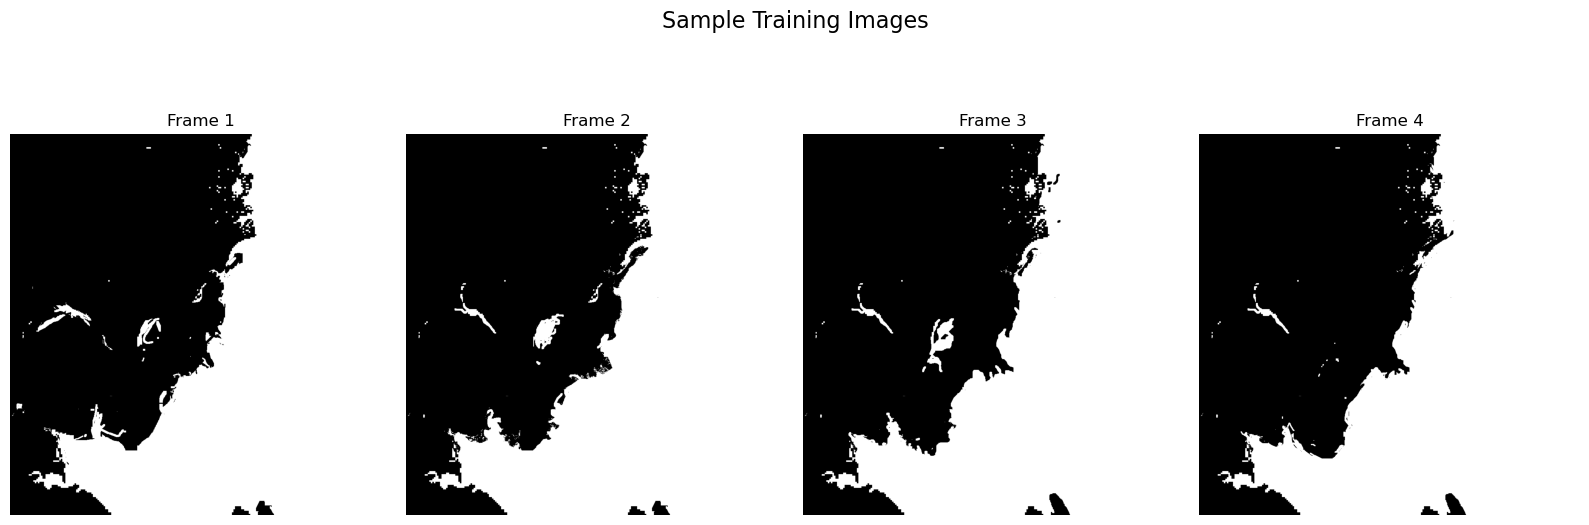

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

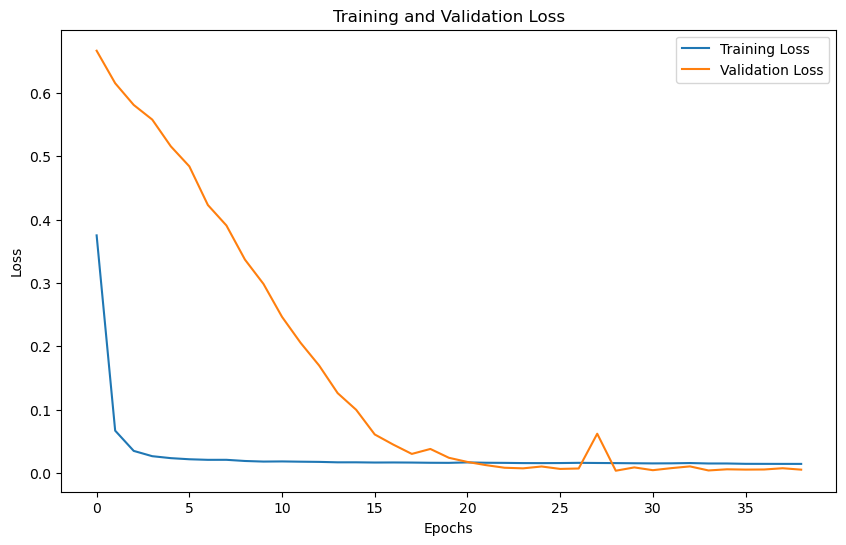

	Min loss: 0.0147
	Min val_loss: 0.0039


INFO:tensorflow:Assets written to: 040824_120 Days in 2023 starting at day 90.h5py\assets


INFO:tensorflow:Assets written to: 040824_120 Days in 2023 starting at day 90.h5py\assets


	Input data of image files: (4, 1, 1000, 1000)
	Swap axes: (1, 4, 1000, 1000)
	Reshaped array for model: (1, 4, 1000, 1000, 1)
1/1 [==============================] - 2s 2s/step


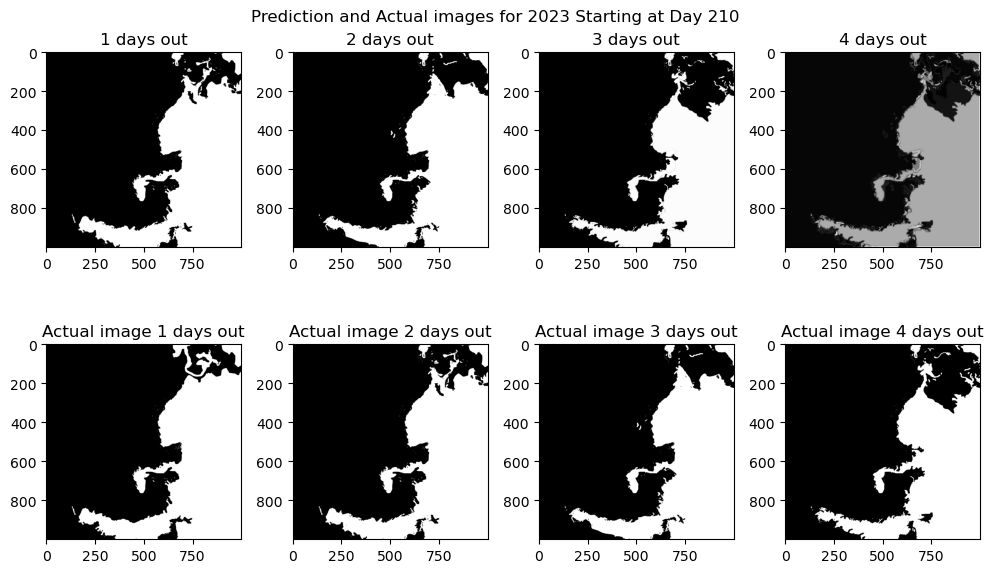

CPU times: total: 20min 53s
Wall time: 28min 7s


In [22]:
%%time
day_range = [
    (1, "January"),
    (2, "February"),
    (3, "March"),
    (4, "April"),
    (5, "May"),
    (6, "June"),
    (7, "July"),
    (8, "August"),
    (9, "September"),
    (10, "October"),
    (11, "November"),
    (12, "December"),
]

# for mon_ord, mon_text in day_range:
#     print(f"Running model for range {mon_text}")
#     img_array = build_array_weeks(2023, 121, weeks=8)
# #     img_array = build_array(years = range(2015, 2024), days = range(1, 5))
#     train_dataset, val_dataset, x_train, y_train, x_val, y_val = create_datasets(img_array)
#     plot_orig_imgs(train_dataset, mon_text)
#     model = build_model()
#     model = fit_model(model, mon_text)
#     predict(model, val_dataset, mon_text)

WINDOW_SIZE = 1000
root_dir = get_path(["D:", "IceDyno", "IMS_images_beaufort"])
mon_text = "120 Days in 2023 starting at day 90"
print(f"Running model for 120 Days in 2023 starting at day 90")

img_array = build_array_weeks(year=2023, start_day=90, sets=30, days_per_set=4)
train_dataset, val_dataset, x_train, y_train, x_val, y_val = create_datasets(img_array)
plot_orig_imgs(train_dataset)
model = build_model()
model = fit_model(model, mon_text)
test_dataset = build_array_weeks(
    year=2023, start_day=210, sets=1, days_per_set=4
)  # Next four days after training/validation
predict_test(model, test_dataset)